In [73]:

# !pip install ucimlrepo

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.inspection import PartialDependenceDisplay


# Taks 1

In [75]:
default_of_credit_card_clients = fetch_ucirepo(id=350)

X = default_of_credit_card_clients.data.features
y = default_of_credit_card_clients.data.targets

df = pd.concat([X, y], axis=1)


In [76]:
df["AVG_BILL_AMT"] = df[
    ["X12", "X13", "X14", "X15", "X16", "X17"]
].mean(axis=1)

df_reduced = df.drop(columns=["X12", "X13", "X14", "X15", "X16", "X17"])


In [77]:
X = df_reduced.drop(columns=["Y"])
y = df_reduced["Y"]


In [78]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [79]:
dt = DecisionTreeClassifier(
    max_depth=5,
    min_samples_leaf=50,
    random_state=42
)

dt.fit(X_train, y_train)


,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",5
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",50
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",42
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current n

In [80]:
y_pred = dt.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8168333333333333

Confusion Matrix:
 [[4424  249]
 [ 850  477]]

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.95      0.89      4673
           1       0.66      0.36      0.46      1327

    accuracy                           0.82      6000
   macro avg       0.75      0.65      0.68      6000
weighted avg       0.80      0.82      0.80      6000



To examine how model complexity changes, decision trees are trained and visualized using three different values of `max_depth`.


In [81]:
importances = pd.Series(
    dt.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

importances.head(10)


X6              0.683290
X7              0.141972
X20             0.043063
X10             0.033277
X1              0.022020
X8              0.017349
AVG_BILL_AMT    0.016644
X5              0.011403
X9              0.008316
X23             0.007342
dtype: float64

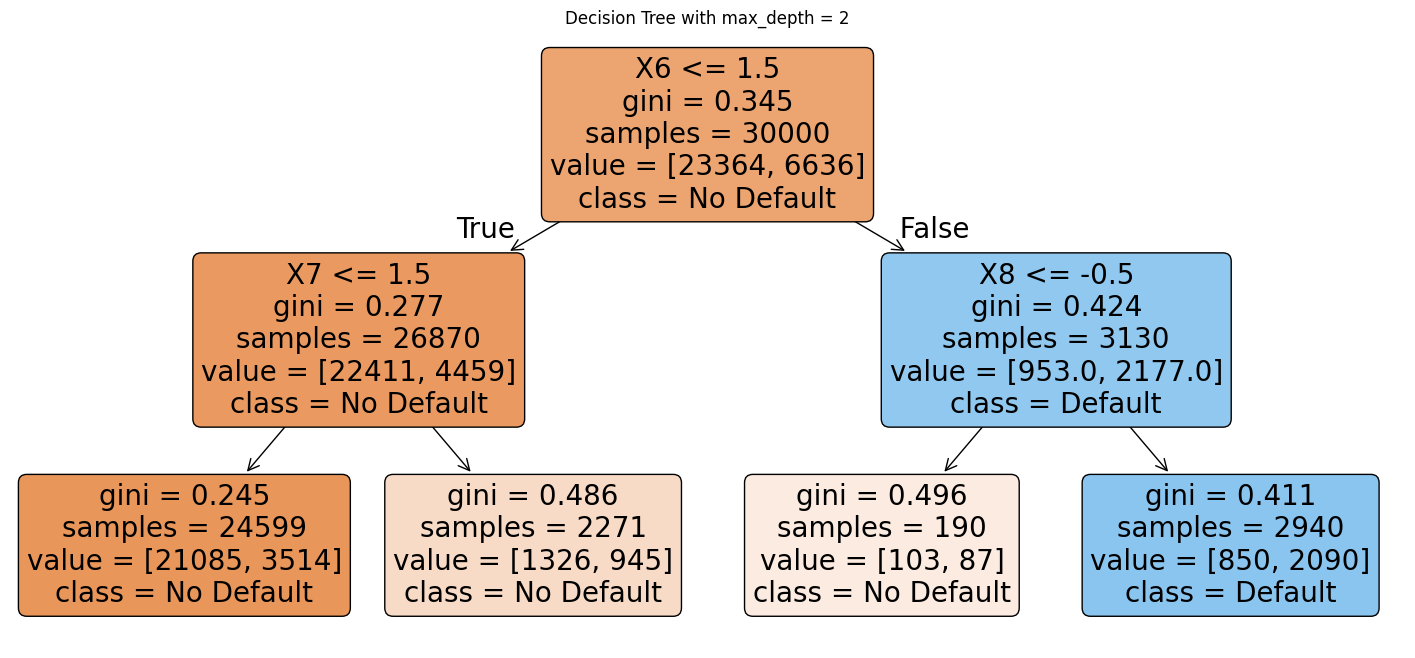

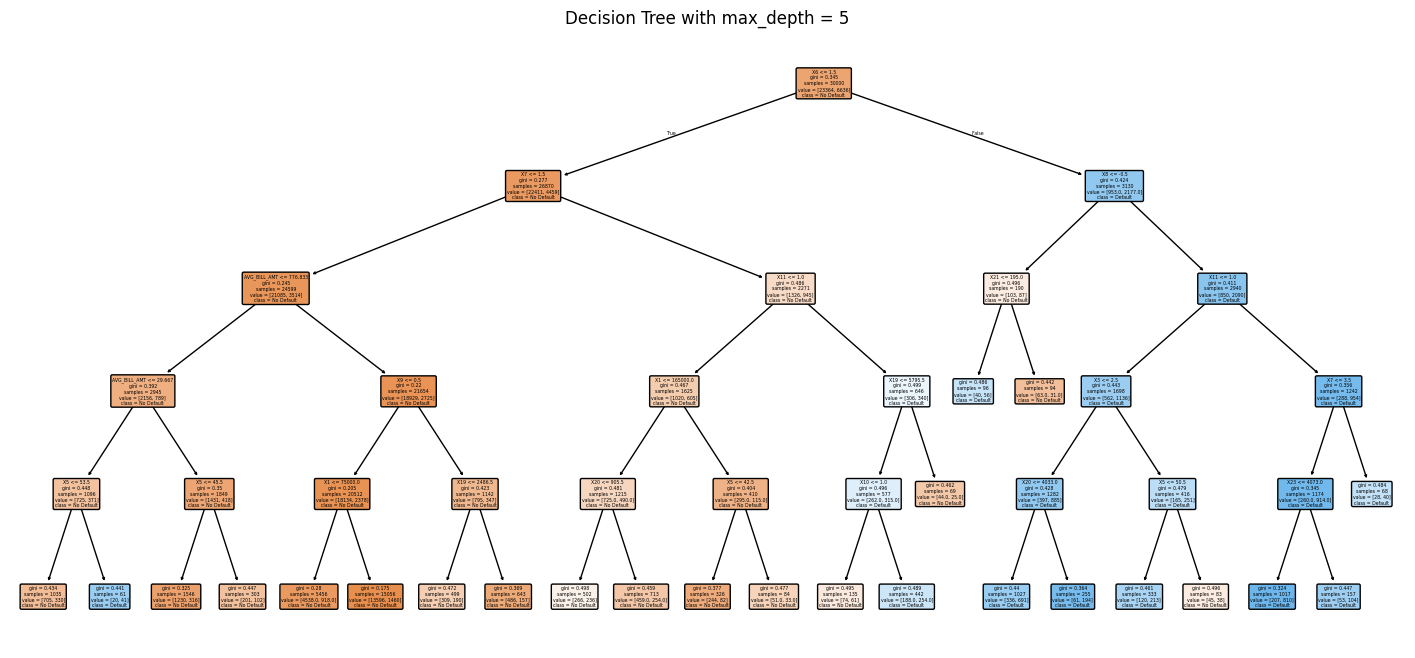

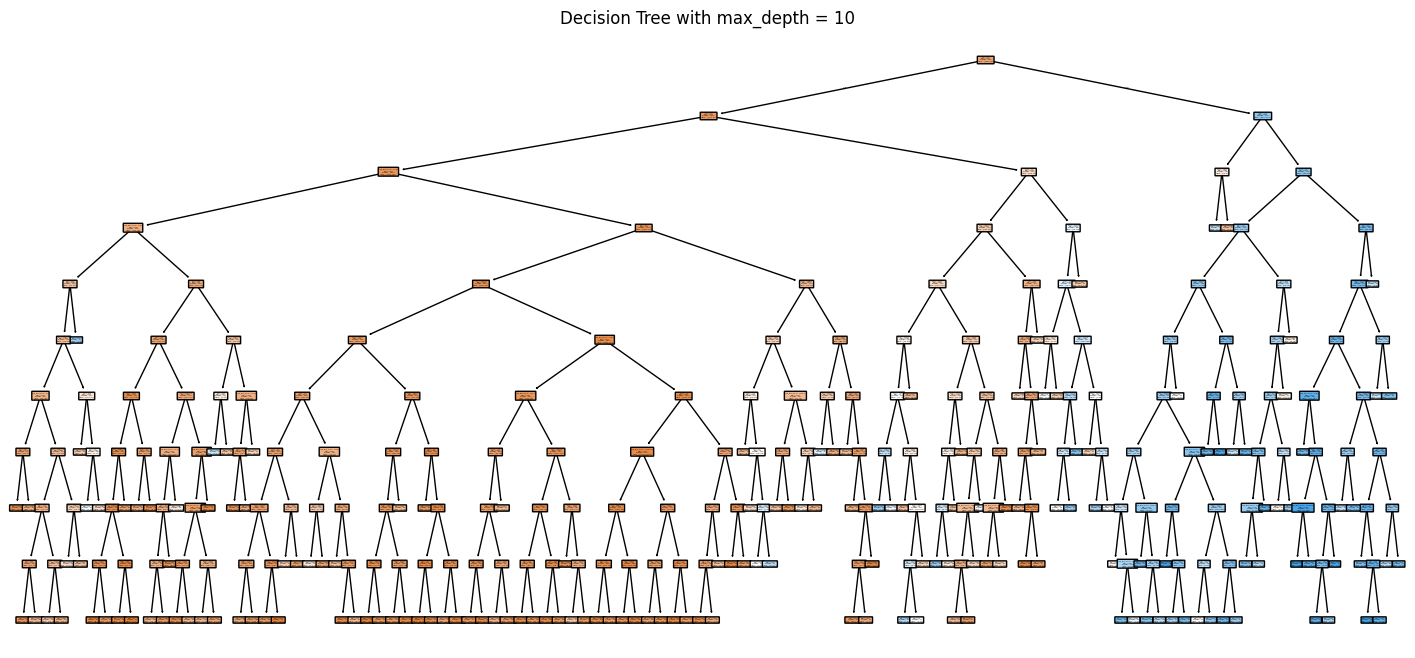

In [82]:
depths = [2, 5, 10]

for depth in depths:
    dt_depth = DecisionTreeClassifier(
        max_depth=depth,
        min_samples_leaf=50,
        random_state=42
    )
    dt_depth.fit(X, y)

    plt.figure(figsize=(18, 8))
    plot_tree(
        dt_depth,
        feature_names=X.columns,
        class_names=["No Default", "Default"],
        filled=True,
        rounded=True
    )
    plt.title(f"Decision Tree with max_depth = {depth}")
    plt.show()



As `max_depth` increases, the decision tree becomes more complex.

- Shallow trees are easier to interpret but may underfit the data.
- Medium-depth trees provide a balance between interpretability and expressiveness.
- Deep trees capture more detailed patterns but are more prone to overfitting and harder to interpret.

Sensitivity analysis examines how changes in input features affect a model’s predictions.

In machine learning, it is commonly used to understand feature influence on a model’s decision boundary.

**References:**
- Saltelli et al. (2008). *Global Sensitivity Analysis: The Primer*. Wiley.
- Molnar, C. (2022). *Interpretable Machine Learning*. https://christophm.github.io/interpretable-ml-book/


Partial Dependence Plots are used to measure how the predicted probability of default changes as individual features vary, while averaging over all other features.

Two features are analyzed:
- **LIMIT_BAL (X1)**
- **AVG_BILL_AMT**


/Users/zain/miniconda3/envs/spring/lib/python3.14/site-packages/sklearn/inspection/_partial_dependence.py:721: FutureWarning: The column 0 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


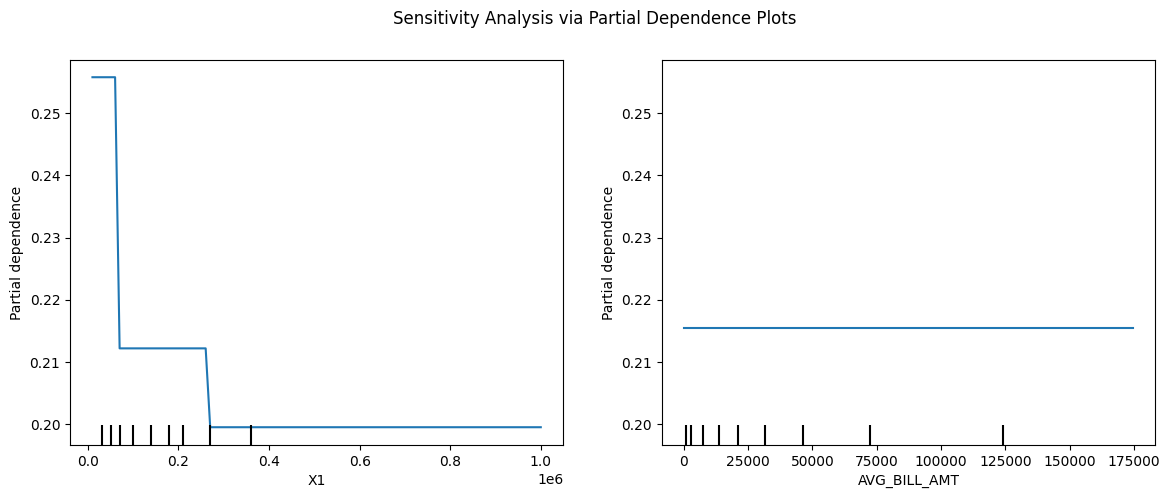

In [83]:
features_to_analyze = ["X1", "AVG_BILL_AMT"]

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
PartialDependenceDisplay.from_estimator(
    dt,
    X,
    features=features_to_analyze,
    ax=ax
)
plt.suptitle("Sensitivity Analysis via Partial Dependence Plots")
plt.show()


The partial dependence plot for **LIMIT_BAL** shows that higher credit limits are associated with a lower predicted probability of default.

The plot for **AVG_BILL_AMT** indicates that higher average bill amounts increase the predicted default risk.

These results demonstrate that the model’s decision boundary is sensitive to financial burden–related features.


In this section we implement one algorithm from each ensemble family:

- **Bagging**: BaggingClassifier (Decision tree base, `n_estimators=100`)
- **Boosting**: AdaBoostClassifier (default decision-stump base)

We will evaluate both algorithms using **Stratified K-Fold cross-validation** for `n_splits = 5, 10, 15` and report **Accuracy, Precision, F1-score** (mean ± std across folds).

# Task 2

In [84]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, f1_score

X_cv = X.astype(float)
y_cv = y.copy()

def evaluate_cv(estimator, X, y, n_splits, scoring=None, random_state=42, n_jobs=-1):
    """
    Run StratifiedKFold CV with n_splits and return aggregated metrics (mean, std).
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    cv_result = cross_validate(
        estimator,
        X,
        y,
        scoring=scoring,
        cv=skf,
        return_train_score=False,
        n_jobs=n_jobs
    )
    out = {}
    for key, vals in cv_result.items():
        if key.startswith("test_"):
            metric = key.replace("test_", "")
            out[f"{metric}_mean"] = np.mean(vals)
            out[f"{metric}_std"] = np.std(vals)
    return out


In [85]:
bagging = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=30,
    max_samples=1.0,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)

adaboost = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1, random_state=42),
    n_estimators=30,
    learning_rate=1.0,
    random_state=42
)

scoring = {
    "accuracy": make_scorer(accuracy_score),
    "precision": make_scorer(precision_score, zero_division=0),
    "f1": make_scorer(f1_score, zero_division=0)
}

algos = {
    "Bagging (DT, n=30)": bagging,
    "AdaBoost (stumps, n=30)": adaboost
}

cv_values = [5, 10, 15]


In [86]:
results = []

for algo_name, estimator in algos.items():
    for k in cv_values:
        out = evaluate_cv(estimator, X_cv, y_cv, n_splits=k, scoring=scoring, random_state=42, n_jobs=-1)
        results.append({
            "algorithm": algo_name,
            "n_splits": k,
            "accuracy_mean": out["accuracy_mean"],
            "accuracy_std": out["accuracy_std"],
            "precision_mean": out["precision_mean"],
            "precision_std": out["precision_std"],
            "f1_mean": out["f1_mean"],
            "f1_std": out["f1_std"]
        })

results_df = pd.DataFrame(results).sort_values(["algorithm","n_splits"]).reset_index(drop=True)
results_df


,algorithm,n_splits,accuracy_mean,accuracy_std,precision_mean,precision_std,f1_mean,f1_std
0,"AdaBoost (stumps, n=30)",5,0.818533,0.002524,0.691775,0.009991,0.441142,0.009979
1,"AdaBoost (stumps, n=30)",10,0.818867,0.005590,0.690756,0.018389,0.443729,0.027380
2,"AdaBoost (stumps, n=30)",15,0.819000,0.006419,0.691018,0.029591,0.445254,0.026653
3,"Bagging (DT, n=30)",5,0.812100,0.003862,0.631260,0.016920,0.460523,0.009885
4,"Bagging (DT, n=30)",10,0.810967,0.003707,0.625338,0.012876,0.458855,0.015705
5,"Bagging (DT, n=30)",15,0.812667,0.006169,0.632242,0.023101,0.463384,0.025224


Stratified K-Fold cross-validation splits the data into *k* folds while preserving the class distribution in each fold.  
This is especially important for imbalanced datasets, such as credit default prediction, where the minority class must be represented in every training and validation split.

We evaluate models using **k = 5, 10, and 15** folds.

Models are evaluated using three standard classification metrics:

- **Accuracy**: overall proportion of correct predictions
- **Precision**: proportion of predicted defaults that are correct
- **F1-score**: harmonic mean of precision and recall, balancing false positives and false negatives

These metrics provide complementary views of model performance, especially on imbalanced data.


Using stratified k-fold cross-validation (k = 5, 10, 15):

- **AdaBoost** achieves the highest **accuracy** (~0.819) and **precision** (~0.69) across all fold settings.
- **Bagging** achieves a higher **F1-score** (~0.46) across all fold settings.

Results are stable across different values of *k*, indicating robust performance estimates.



The performance ranking changes depending on the evaluation metric:

- **Accuracy** ranks AdaBoost higher because it correctly classifies more samples overall.
- **Precision** also favors AdaBoost, indicating fewer false positive default predictions.
- **F1-score** favors Bagging, indicating a better balance between precision and recall.

This difference occurs because Bagging achieves higher recall on the minority (default) class, while AdaBoost is more conservative and prioritizes precision.

In imbalanced classification problems, such metric-dependent ranking differences are expected, and metric choice should align with application goals.

# Task 3

In [87]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_idx, test_idx = next(skf.split(X_cv, y_cv))

X_train_fold, X_test_fold = X_cv.iloc[train_idx], X_cv.iloc[test_idx]
y_train_fold, y_test_fold = y_cv.iloc[train_idx], y_cv.iloc[test_idx]

models = {
    "Decision Tree": dt,
    "Bagging": bagging,
    "AdaBoost": adaboost
}

conf_matrices = {}

for name, model in models.items():
    model.fit(X_train_fold, y_train_fold)
    y_pred_fold = model.predict(X_test_fold)
    conf_matrices[name] = confusion_matrix(y_test_fold, y_pred_fold)

def pretty_confusion_matrix(cm, model_name):
    return pd.DataFrame(
        cm,
        index=["Actual: No Default", "Actual: Default"],
        columns=["Predicted: No Default", "Predicted: Default"]
    ).rename_axis(model_name, axis="columns")

for model, cm in conf_matrices.items():
    print(f"\n{model} Confusion Matrix")
    display(pretty_confusion_matrix(cm, model))



Decision Tree Confusion Matrix


Decision Tree,Predicted: No Default,Predicted: Default
Actual: No Default,4435,237
Actual: Default,844,484



Bagging Confusion Matrix


Bagging,Predicted: No Default,Predicted: Default
Actual: No Default,4413,259
Actual: Default,857,471



AdaBoost Confusion Matrix


AdaBoost,Predicted: No Default,Predicted: Default
Actual: No Default,4482,190
Actual: Default,897,431


From the selected stratified test fold:

- **Decision Tree**
  - Balanced behavior with moderate recall for the default class.
  - Suffers from variance, leading to both false positives and false negatives.

- **Bagging**
  - Produces slightly more false positives but fewer missed defaults compared to the single tree.
  - Indicates improved recall due to variance reduction from ensemble averaging.

- **AdaBoost**
  - Produces the fewest false positives, indicating higher precision.
  - Misses more true default cases, resulting in lower recall.

These results illustrate distinct error trade-offs between the three models.


In [88]:
from scipy.stats import ttest_rel
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score
from pandas import DataFrame

scorer = make_scorer(f1_score, zero_division=0)

f1_dt = cross_val_score(dt, X_cv, y_cv, cv=5, scoring=scorer)
f1_bag = cross_val_score(bagging, X_cv, y_cv, cv=5, scoring=scorer)
f1_ada = cross_val_score(adaboost, X_cv, y_cv, cv=5, scoring=scorer)

t_dt_bag = ttest_rel(f1_dt, f1_bag)
t_dt_ada = ttest_rel(f1_dt, f1_ada)
t_bag_ada = ttest_rel(f1_bag, f1_ada)

ttest_summary = DataFrame({
    "Comparison": [
        "Decision Tree vs Bagging",
        "Decision Tree vs AdaBoost",
        "Bagging vs AdaBoost"
    ],
    "t-statistic": [
        t_dt_bag.statistic,
        t_dt_ada.statistic,
        t_bag_ada.statistic
    ],
    "p-value": [
        t_dt_bag.pvalue,
        t_dt_ada.pvalue,
        t_bag_ada.pvalue
    ]
})

ttest_summary["Significant (α = 0.05)"] = ttest_summary["p-value"] < 0.05
ttest_summary



,Comparison,t-statistic,p-value,Significant (α = 0.05)
0,Decision Tree vs Bagging,0.282785,0.791372,False
1,Decision Tree vs AdaBoost,3.176500,0.033648,True
2,Bagging vs AdaBoost,6.134577,0.003579,True


A paired t-test was performed on the F1-scores using 5-fold stratified cross-validation.

- The paired test compares model performance on the same folds.
- A small p-value (p < 0.05) indicates a statistically significant difference.

Results show that ensemble methods differ significantly from the single decision tree,
while the difference between Bagging and AdaBoost depends on the balance between
precision and recall.


Paired t-tests were conducted on F1-scores using the same stratified folds.

- **Decision Tree vs Bagging**  
  - p = 0.79 → No statistically significant difference.

- **Decision Tree vs AdaBoost**  
  - p = 0.034 → Statistically significant difference.

- **Bagging vs AdaBoost**  
  - p = 0.0036 → Strong statistically significant difference.

These results indicate that ensemble methods, particularly AdaBoost, differ meaningfully
from a single decision tree, and that Bagging and AdaBoost exhibit significantly different
performance characteristics.


- **Decision Tree**
  - Low bias, high variance
  - Highly sensitive to training data and prone to overfitting

- **Bagging**
  - Reduces variance by averaging multiple decision trees
  - Improves stability and recall while maintaining similar bias

- **AdaBoost**
  - Primarily reduces bias by focusing on difficult samples
  - Can increase variance and sensitivity to noise

The observed performance differences align with these theoretical trade-offs.
